In [2]:
%matplotlib inline

from pymongo import MongoClient
import matplotlib.pyplot as plt
import math
import numpy as np
import gpxpy.geo
from tqdm import tqdm
from collections import defaultdict
from sklearn.cluster import KMeans
import json
from sklearn.cluster import KMeans

client = MongoClient()
db = client.yelp

# Calculating Radi

In [3]:
def get_all_reviews_by_user_for_city(city):
    """A function which queries for all the reviews associated to all the buisnesses in a city
    returns a dict (biz_id : review_locations)"""
    bizes = list(db.businesses.find({"city": city}, { "business_id": 1, "latitude": 1, "longitude": 1, "categories": 1}))
    user_reviews = defaultdict(list)
    for biz in tqdm(bizes):
        biz_id = biz['business_id']
        rel_review = db.reviews.find({"business_id": biz_id})
        for review in list(rel_review):
            user_reviews[review['user_id']].append((biz["latitude"], biz["longitude"]))
    return user_reviews

In [4]:
henderson_reviews = get_all_reviews_by_user_for_city("Henderson")

100%|██████████| 3788/3788 [00:05<00:00, 748.24it/s]


In [5]:
print henderson_reviews["vaHK_3WyoLaSYmtmdFL-EQ"]

[(36.019323, 115.086769)]


In [6]:
#Manipulating Latitude and Longitude
def get_average_lat_and_long(set_lat_by_long):
    """We get some wierd outliers from the 'set_lat_by_long' we'll need to take care of these some how
    returns: the average latitude and longitude 
    NOTE: this is simply the average of the latitude and longitude values (not based on geodicics)"""
    set_lat_by_long = np.asarray(set_lat_by_long).copy()
    return np.average(set_lat_by_long, axis=0)

def get_max_distacne_from_mid(set_lat_by_long):
    """Because of the outliers (these are caused by a missing sign) get_average_lat_and_long returns a point 
    that is very far from the actual center"""
    set_lat_by_long = np.asarray(set_lat_by_long)
    mid = get_average_lat_and_long(set_lat_by_long)
    return np.max([gpxpy.geo.haversine_distance(mid[0], mid[1], lat, lon)/1609.34 for lat, lon in set_lat_by_long])


## Dealing with These Outliers

Sklearn provides some Outlier detection methods that are robust, such as <a href="http://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope">EllipticEnvelope</a> and <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest">IsolationForest</a>.

Before thinking to consult sklearn for methods concerning outlier detection I developed one (that will not generalize by any means) using K means. 

Bassically the idea is that no city is bigger than 100 Miles, so if any given distance from the center is over 100 miles split the clusters into two sperate clusters. 

### Providing examples of the problem
For this example we'll use "henderson_reviews" since its pretty small, and I know the city of Henderson very well, so I will be able to determine BS more so than I would for any other city. 

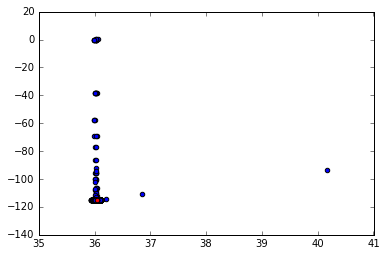

In [7]:
def get_all_centers_as_array(reviews_dict):
    x_centers_list = []
    y_centers_list = []
    associated_id = []
    for uid, user_review in reviews_dict.iteritems():
        if len(user_review) == 1:
            continue #We don't care about single reviewers! They give us no information.
        x, y = get_average_lat_and_long(user_review)
        x_centers_list.append(x)
        y_centers_list.append(y)
        associated_id.append(uid)
    return np.array([x_centers_list, y_centers_list]).T, associated_id

def visualize_locations(reviews_dict, city_loc=(36.0395, -114.9817)):
    #Default values set to be appropriate for henderson
    centers = get_all_centers_as_array(reviews_dict)[0]
    plt.scatter(centers[:, 0], centers[:, 1])
    if city_loc:
        plt.scatter(city_loc[0], city_loc[1], c='r')
    return plt

def get_bad_point(reviews_dict, y_bad=-1):
    bad_points = None
    for uid, user_review in reviews_dict.iteritems():
        x, y = get_average_lat_and_long(user_review)
        if y > y_bad:
            bad_points = user_review
    return bad_points

bad_point = get_bad_point(henderson_reviews)
visualize_locations(henderson_reviews).show()

That red dot near the 36 tick is the actual location of Henderson. 36' N 0' E (toward the top of that line) is a location just north of Algeria. Over 5000 miles away! And that is the CENTER! (That means that one of the points is in Asia or something!) Henderson isn't quite that big, infact henderson is contained completely between: (35.891588, -115.218488) and (36.130405, -114.914276)!

We have stored this center in conneticut in the variable "bad_points" in order to futher investigate the issue.

This is obviously and issue as some of the reviews radius will be over 2000 miles! Surely a bikeshop in Henderson can't view a bikeshop in Connecticut as a competitor! That is out ragous. 

In [8]:
bad_point

[(36.019323, 115.086769), (35.9658025616, -115.169019763)]

As I mentioned before the data it appears as though our data is missing signs randomly. Unfortunately checking if a point is in a city is non trivial, so we cannot simply look for places which signs should change. Instead we will combat this by methods below. 

### Naive K means Outlier Removal
This next approach, while Naive, emperically at least leaves a cluster which is far more reasonable. 

In [9]:
def get_clusters(data, n_clusters=2):
    kmeans = KMeans(n_clusters=2).fit(data)
    centers = kmeans.cluster_centers_
    to_return = [[] for i in range(len(centers))]
    for x in data:
        dist = np.linalg.norm(centers - x, 1, axis=1)
        index = np.argmin(dist)
        to_return[index].append(x)
    #Below we make the assumption that the most points are found in a given city at least!
    return sorted([np.vstack(i) for i in to_return], key=lambda x: len(x))[::-1]

In [10]:
def clean_reviewer_average_radius_with_get_clusters(reviews):
    good_points = {}
    for i, dict_pair in enumerate(reviews.iteritems()):
        key, val = dict_pair
        if len(val) > 1:
            dis_from_mid = get_max_distacne_from_mid(val)
            k = 2
            while dis_from_mid > 100: #cities are never bigger than 100 miles in diameter
                val = get_clusters(val, n_clusters=k)[0] #select the data with the most points
                k += 1
                dis_from_mid = get_max_distacne_from_mid(val)
            good_points[key] = val
    return good_points

In [1]:
henderson_reviews = clean_reviewer_average_radius_with_get_clusters(henderson_reviews)

NameError: name 'clean_reviewer_average_radius_with_get_clusters' is not defined

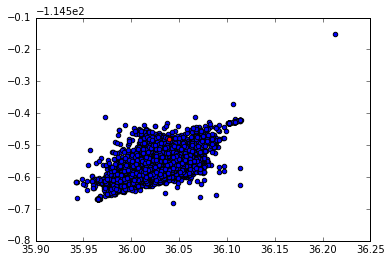

In [12]:
visualize_locations(henderson_reviews).show()
weird_point = get_bad_point(henderson_reviews, y_bad=-1.145e2-0.2)

As you can see these centers make much more sense. At very least all except one point is found in city boundries. (remeber these are the centers, not necessarily all of these radiuses are in the city limits, this is probably all right though, because in aggregate it is not a major factor (considering the density of points just off center). 

That one point off in the corner is still a little funky though, so we'll take a look at it. 

In [13]:
weird_point

[(36.1964602504, -114.687223434), (36.2301533225, -114.61264934)]

Both of these points seem to be just barely out of city limits (yelp likely considers them part of the city), the fact that this radius is so small just outside of the city may be a bad sign, and even be an error, however, we'll minimize the adverse effects for this perfered efficentcy and simplicity by weighting our radi based on the number of reviews done. (We disscuss this in futher in the next cell)

#### Competitive Region Result
For reviewers who left more reviews in a city we are more confident that they are local and thus better represent the actual "radius of competition" it is for this reason that we weight based on the number of reviews a given review left.


In [19]:
def get_radius_from_review_centers_dict(review_centers_dict, tol=1):
    review_center_radi = []
    review_center_weights = []
    for val in review_centers_dict.values():
        dis_from_mid = get_max_distacne_from_mid(val)
        review_center_radi.append(dis_from_mid)
        review_center_weights.append(len(val))
    return np.dot(np.array(review_center_weights).T, np.array(review_center_radi))/np.sum(review_center_weights)

In [20]:
print get_radius_from_review_centers_dict(henderson_reviews)

67.5558676146


### EllipticEnvelope

A indepth tutorial for this method (which was used to apply to this data) can be found at: <a href="http://scikit-learn.org/stable/auto_examples/applications/plot_outlier_detection_housing.html#sphx-glr-auto-examples-applications-plot-outlier-detection-housing-py"> scikits website </a>

In [18]:
henderson_reviews = get_all_reviews_by_user_for_city("Henderson")

100%|██████████| 3788/3788 [00:03<00:00, 947.89it/s]


#### Visualizing the boundry
In order to quickly determine how useful the EllipticEnvelope method might be useful I visualize it below.

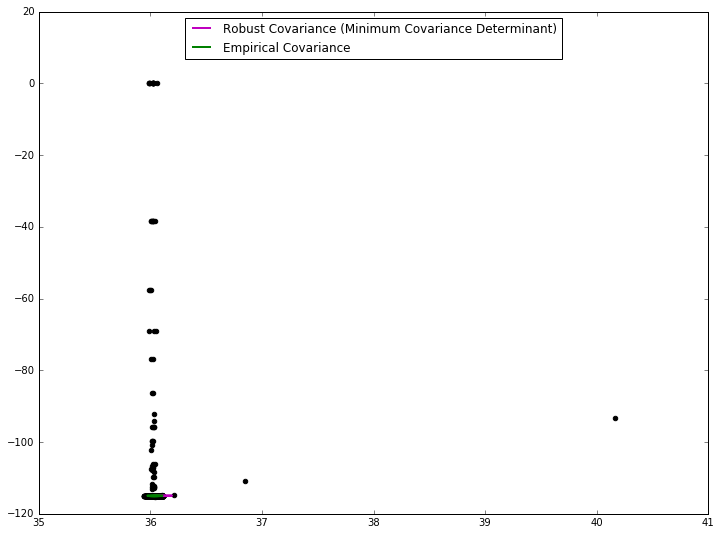

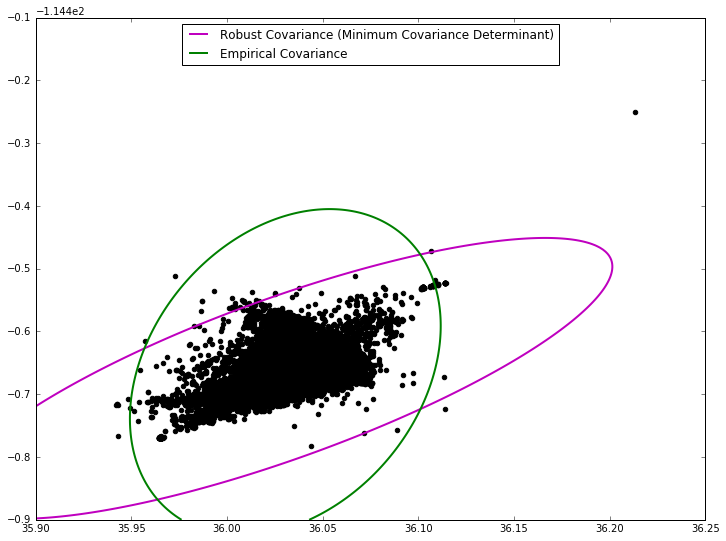

In [21]:
import numpy as np
from sklearn.covariance import EllipticEnvelope
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.datasets import load_boston

# Get data
X1 = get_all_centers_as_array(henderson_reviews)[0]  # two clusters

# Define "classifiers" to be used
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.,
                                             contamination=0.005),
    "Robust Covariance (Minimum Covariance Determinant)":
    EllipticEnvelope(contamination=0.005)}
colors = ['m', 'g', 'b']
legend1 = {}

# Learn a frontier for outlier detection with several classifiers
for xx, yy in [((35, 41), (-120, 20)), ((35.90, 36.25), (-114.5, -115.3))]:
    plt.figure(figsize=(12, 9))
    xx1, yy1 = np.meshgrid(np.linspace(xx[0], xx[1], 250), np.linspace(yy[0], yy[1], 250))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        plt.figure(1)
        clf.fit(X1)
        Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
        Z1 = Z1.reshape(xx1.shape)
        legend1[clf_name] = plt.contour(
            xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i])

    legend1_values_list = list(legend1.values())
    legend1_keys_list = list(legend1.keys())

    # Plot the results (= shape of the data points cloud)
    #plt.title("Outlier detection on a real data set (boston housing)")
    plt.scatter(X1[:, 0], X1[:, 1], color='black')

    plt.xlim((xx1.min(), xx1.max()))
    plt.ylim((yy1.min(), yy1.max()))
    plt.legend((legend1_values_list[0].collections[0],
                legend1_values_list[1].collections[0]),
               (legend1_keys_list[0], legend1_keys_list[1]),
               loc="upper center",
               prop=matplotlib.font_manager.FontProperties(size=12))

    plt.show()

SKlearn suggests using the default value for the `support_fraction` parameter, so we will (this gives the purple boundry)

This method seems to work very well! However I don't totally understand how it is working, so I read (and suggest reading) http://www.geo.upm.es/postgrado/CarlosLopez/papers/FastAlgMCD99.pdf

The algorithm used is NOT an EM algorithm, but rather a MM algorithm (Majorize-Minimization). To read more specifics about it's innner workings also check out: https://wis.kuleuven.be/stat/robust/papers/2010/wire-mcd.pdf

In [27]:
def clean_reviewer_average_radius_with_EllipticEnvelope(reviews):
    good_points = {}
    classifier = EllipticEnvelope(contamination=0.005)
    centers, user_ids = get_all_centers_as_array(reviews)
    classifier.fit(centers)
    inlier_indexes = np.where(classifier.predict(centers) != -1)
    user_ids = np.array(user_ids)[inlier_indexes]
    for i, user_id in enumerate(user_ids):
        good_points[user_id] = reviews[user_id]
    return good_points

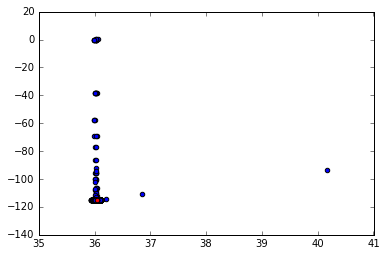

In [28]:
visualize_locations(henderson_reviews).show()

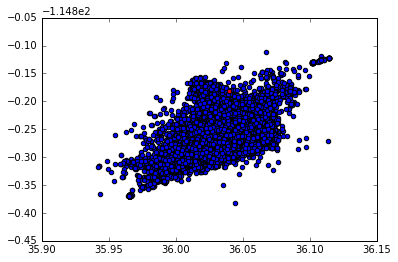

In [29]:
visualize_locations(clean_reviewer_average_radius_with_EllipticEnvelope(henderson_reviews)).show()

#### Benefits to this model 

1) If a city is over 100 miles in diameter this model will continue to work

2) It's more than emperical, there is some hard mathematics that has been developed regarding the statistics behind this method

3) That `weird point` that I mentioned before that is out of the city happens to not be in the set at all.

#### Competitive Region Result


In [37]:
get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_EllipticEnvelope(henderson_reviews))

4.3851076456277456

### Random Forest for Anomaly Detection (Isolation Forest)

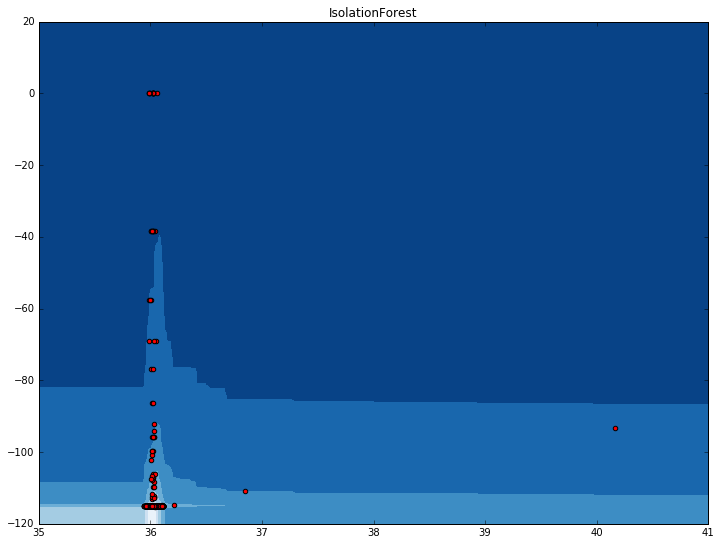

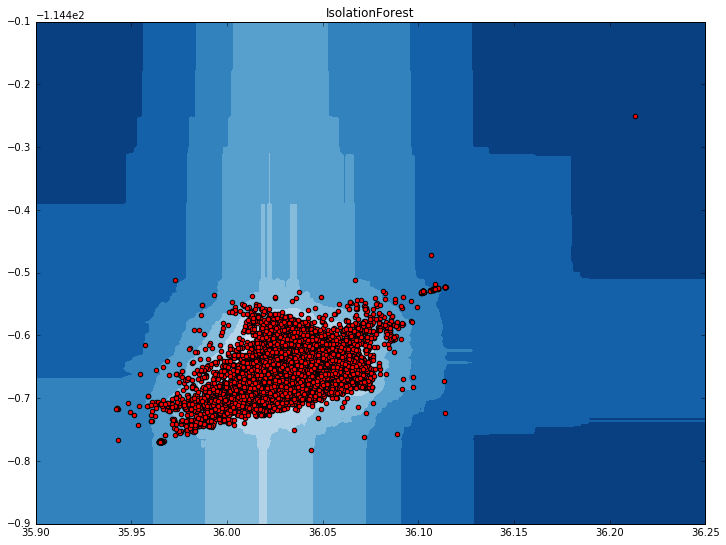

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

plt.figure(figsize=(12, 9))
rng = np.random.RandomState(42)

# Generate train data
X = get_all_centers_as_array(henderson_reviews)[0]

# fit the model
clf = IsolationForest(max_samples=1500, random_state=rng, contamination=0.005, n_jobs=-1)
clf.fit(X)

for xx_t, yy_t in [((35, 41), (-120, 20)), ((35.90, 36.25), (-114.5, -115.3))]:
    plt.figure(figsize=(12, 9))
    xx, yy = np.meshgrid(np.linspace(xx_t[0], xx_t[1], 250), np.linspace(yy_t[0], yy_t[1], 250))
    # plot the line, the samples, and the nearest vectors to the plane
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.title("IsolationForest")
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

    c = plt.scatter(X[:, 0], X[:, 1], c='red')
    plt.axis('tight')
    plt.xlim((xx.min(), xx.max()))
    plt.ylim((yy.min(), yy.max()))
    plt.show()

In [19]:
def clean_reviewer_average_radius_with_IsolationForest(reviews):
    good_points = {}
    classifier = IsolationForest(max_samples=1500, random_state=rng, contamination=0.005, n_jobs=-1)
    centers, user_ids = get_all_centers_as_array(reviews)
    classifier.fit(centers)
    inlier_indexes = np.where(classifier.predict(centers) != -1)
    user_ids = np.array(user_ids)[inlier_indexes]
    for i, user_id in enumerate(user_ids):
        good_points[user_id] = reviews[user_id]
    return good_points

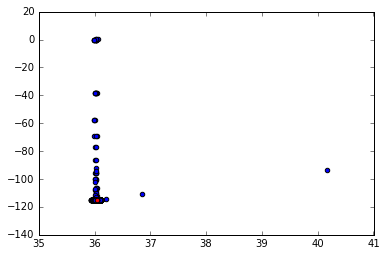

In [20]:
visualize_locations(henderson_reviews).show()

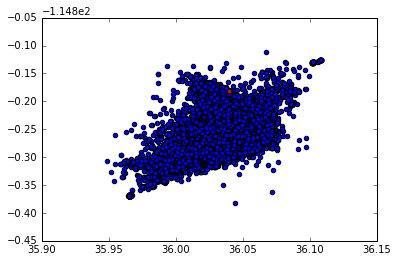

In [38]:
visualize_locations(clean_reviewer_average_radius_with_IsolationForest(henderson_reviews)).show()

WOW! This looks very similar to our Elliptic Envelope! To show that they aren't exactly the same we will plot our three results below: 

#### Benefits to this model 

1) If a city is over 100 miles in diameter this model will continue to work

2) It's more very fast and parrellization comes for free with it, unlike with the EllipticEnvelope.


#### Competitive Region Result

Like we did in the last section we simply apply our `get_radius_from_review_centers_dict` to predict our radius from the result of `clean_reviewer_average_radius_with_IsolationForest`. 

In [39]:
get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_IsolationForest(henderson_reviews))

4.4095566325237305

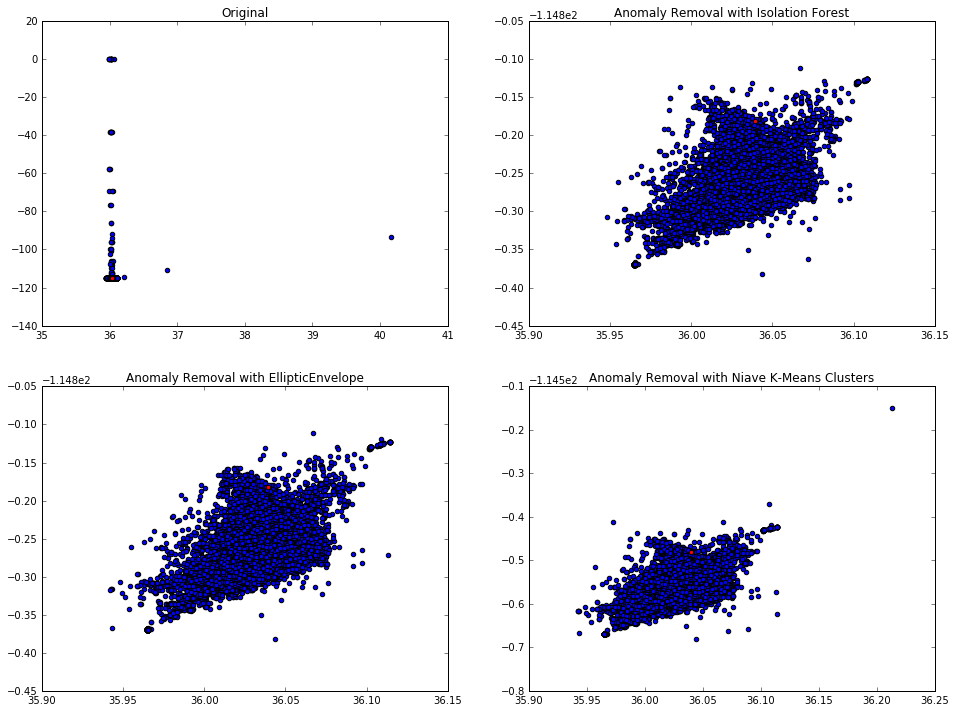

In [22]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
visualize_locations(henderson_reviews).title("Original")
plt.subplot(2, 2, 2)
visualize_locations(clean_reviewer_average_radius_with_IsolationForest(henderson_reviews)).title("Anomaly Removal with Isolation Forest")
plt.subplot(2, 2, 3)
visualize_locations(clean_reviewer_average_radius_with_EllipticEnvelope(henderson_reviews)).title("Anomaly Removal with EllipticEnvelope")
plt.subplot(2, 2, 4)
visualize_locations(clean_reviewer_average_radius_with_get_clusters(henderson_reviews)).title("Anomaly Removal with Niave K-Means Clusters")

plt.show()

### Conclusion

#### Competitive Region Results

From all that I can tell all of the results produced in the above Competitive Region Results are reasonable.

#### Chosing a Method

It's not immediatly discernable which method will be the most effective for our data, however it is pretty clear that Niave K-Means clustering is probably the worst out of the 3 methods described above (besides doing nothing, which is simply unexceptable. We also tuned all of our anamaly perameters based on Henderson, NV only. To make sure that this model generalizes as expected we will also plot Phoenix AZ results. (As a rough sanity check, as everything we have done thus far is unsupervised) We will compare the produced competitve regions as well.

100%|██████████| 14468/14468 [00:13<00:00, 1068.32it/s]


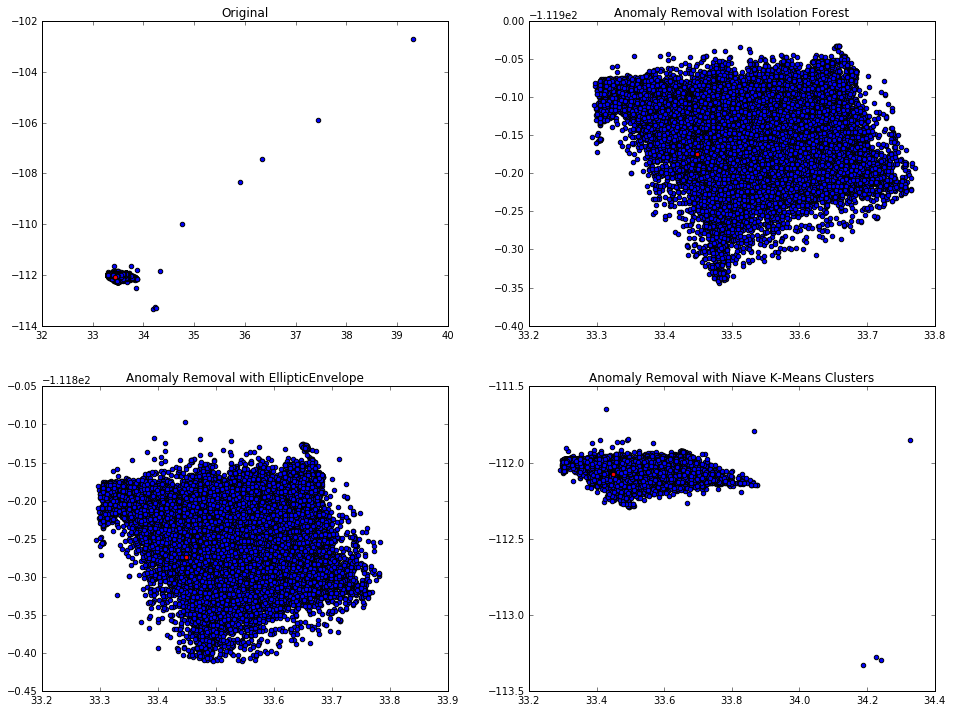

In [23]:
phoenix_reviews = get_all_reviews_by_user_for_city("Phoenix")

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
visualize_locations(phoenix_reviews, (33.448, -112.074)).title("Original")
plt.subplot(2, 2, 2)
visualize_locations(clean_reviewer_average_radius_with_IsolationForest(phoenix_reviews), (33.448, -112.074)).title("Anomaly Removal with Isolation Forest")
plt.subplot(2, 2, 3)
visualize_locations(clean_reviewer_average_radius_with_EllipticEnvelope(phoenix_reviews), (33.448, -112.074)).title("Anomaly Removal with EllipticEnvelope")
plt.subplot(2, 2, 4)
visualize_locations(clean_reviewer_average_radius_with_get_clusters(phoenix_reviews), (33.448, -112.074)).title("Anomaly Removal with Niave K-Means Clusters")

plt.show()

In [42]:
print("Naive K-Means Clusters predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_get_clusters(phoenix_reviews))))
print("Elliptic Envelope predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_EllipticEnvelope(phoenix_reviews))))
print("Isolation Forest predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_IsolationForest(phoenix_reviews))))

Naive K-Means Clusters predicted a radius of: 8.9329
Elliptic Envelope predicted a radius of: 8.9421
Isolation Forest predicted a radius of: 8.9414
